In [64]:
Conversion_const = (
    0.295  # Enter the conversion constant for the transducer in mm/s/(mV)
)


def velocity_cal(chan, Vpp=50.0, conv=Conversion_const, dwell=5.0e-4, period=1.00):
    """
    Velocity calibration function.  Converts channel number 'chan' to velocity with sign
    based on the measured peak-to-peak voltage from the velocity transducer 'Vpp' (in mV),
    the transducer conversion constant 'conv' (in (mm/s)/mV), the channel dwell time
    'dwell' (in s), and the drive period 'period' (in s).
    """
    velocity_period_half = 0.5 * period / dwell

    velocity_max = 0.5 * conv * Vpp

    slope = -2 * velocity_max / velocity_period_half

    return velocity_max + slope * (chan + 0.5)


In [65]:
import numpy as np
import pandas as pd


def load_raw_data(data_string):
    """
    Loads raw Mössbauer data from a string.
    Expected format: two columns, channel number and counts.
    """
    lines = data_string.strip().split("\n")
    channels = []
    counts = []
    for line in lines[1:]:
        try:
            channel, count = map(int, line.split())
            channels.append(channel)
            counts.append(count)
        except ValueError:
            print(
                f"Skipping malformed line: {line}"
            )  # Inform user if a line cannot be parsed
    return np.array(channels), np.array(counts)

In [66]:
import uncertainties as unc
import matplotlib.pyplot as plt
from lmfit.models import QuadraticModel, LorentzianModel

def fit_mossbauer_peaks(data_df, guess_centers, title=None):
    """
    Fit Lorentzian peaks to Mössbauer spectroscopy data
    
    Args:
        data_df: DataFrame with 'Counts' and 'velocity' columns
        guess_centers: List of initial peak center positions
        title: Optional title for output
        
    Returns:
        DataFrame containing fitted peak locations with uncertainties
    """
    number_of_peaks = len(guess_centers)
    
    # Create model with quadratic background and Lorentzian peaks
    model_com = QuadraticModel()
    for i in range(number_of_peaks):
        model_com += LorentzianModel(prefix=f'p{i}_')
    params = model_com.make_params()

    # Set initial parameters
    for i, center in enumerate(guess_centers):
        params[f'p{i}_center'].set(value=center, vary=True)
        params[f'p{i}_amplitude'].set(value=-8000.0*5.15*np.pi, vary=True)
        params[f'p{i}_sigma'].set(value=0.08, vary=True)

    # Perform fit
    model_fit = model_com.fit(data_df['Counts'], params, 
                             x=data_df['velocity'],
                             weights=1/np.sqrt(data_df['Counts']))

    # Plot results
    myfig = plt.figure(figsize=(20,28))
    model_fit.plot(fig=myfig)

    # Extract peak parameters with uncertainties
    peaks = []
    for i in range(number_of_peaks):
        center = model_fit.params[f'p{i}_center']
        # Handle case where stderr might be None
        stderr = center.stderr if center.stderr is not None else 0.0
        peaks.append(unc.ufloat(center.value, stderr))

    # Create output dataframe
    peaks_df = pd.DataFrame({
        'Number': range(1, number_of_peaks + 1),
        'Location (mm/s)': peaks,
        # 'Uncertainty (mm/s)': [peak.std_dev() for peak in peaks]
    })

    if title:
        print(f"\nPeak locations for {title}:")
        print(peaks_df)
        
    return peaks_df, model_fit



In [67]:
import matplotlib.pyplot as plt


def process_sample(filename, guess_centers, title):
    """Process and analyze Mossbauer data for an iron sample.

    Args:
        filename (str): Path to the data file
        guess_centers (list): Initial guesses for peak centers

    Returns:
        tuple: (DataFrame with peak locations, DataFrame with raw data)
    """
    # Load and process data
    with open(filename, "r") as file:
        raw_data = load_raw_data(file.read())

    data_df = pd.DataFrame({"Chan": raw_data[0], "Counts": raw_data[1]})
    data_df["velocity"] = velocity_cal(data_df["Chan"])

    # Plot raw data
    plt.figure(figsize=(12, 9))
    plt.grid()
    plt.xlabel(r"Velocity (mm/s)")
    plt.ylabel(r"Counts")
    plt.title(title)
    plt.plot(data_df["velocity"], data_df["Counts"], ".")

    # Fit peaks and get results
    peaks_df, model_fit = fit_mossbauer_peaks(data_df, guess_centers, title)

    # print a table of fit centers and uncertainties
    # for i, peak in enumerate(peaks_df["Location (mm/s)"]):
    #     print(f"Peak {i+1}: {peak} ± {peaks_df['Uncertainty (mm/s)'][i]}")

    return peaks_df, data_df


Peak locations for Natural Fe 0.001 in:
   Number   Location (mm/s)
0       1  -5.5671+/-0.0011
1       2  -3.2315+/-0.0012
2       3  -0.9248+/-0.0018
3       4   0.8272+/-0.0018
4       5   3.1208+/-0.0012
5       6   5.4041+/-0.0010


/Users/bowanglan/Dev/academic/phys-431/mossbauer-spectroscopy/.venv/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


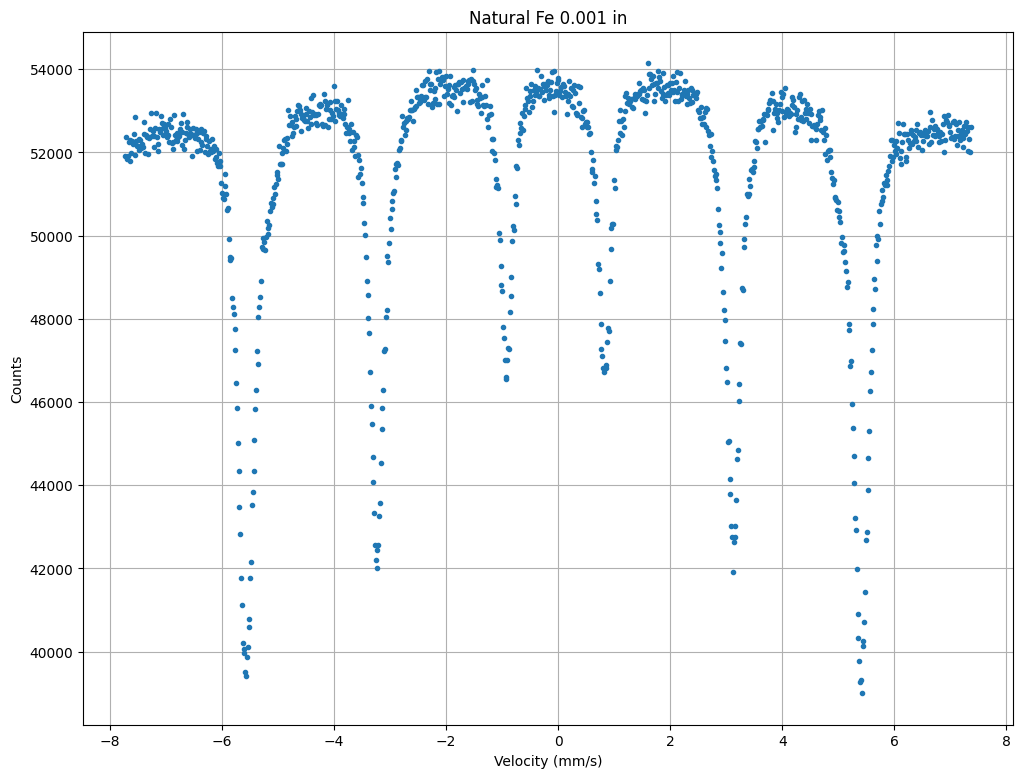

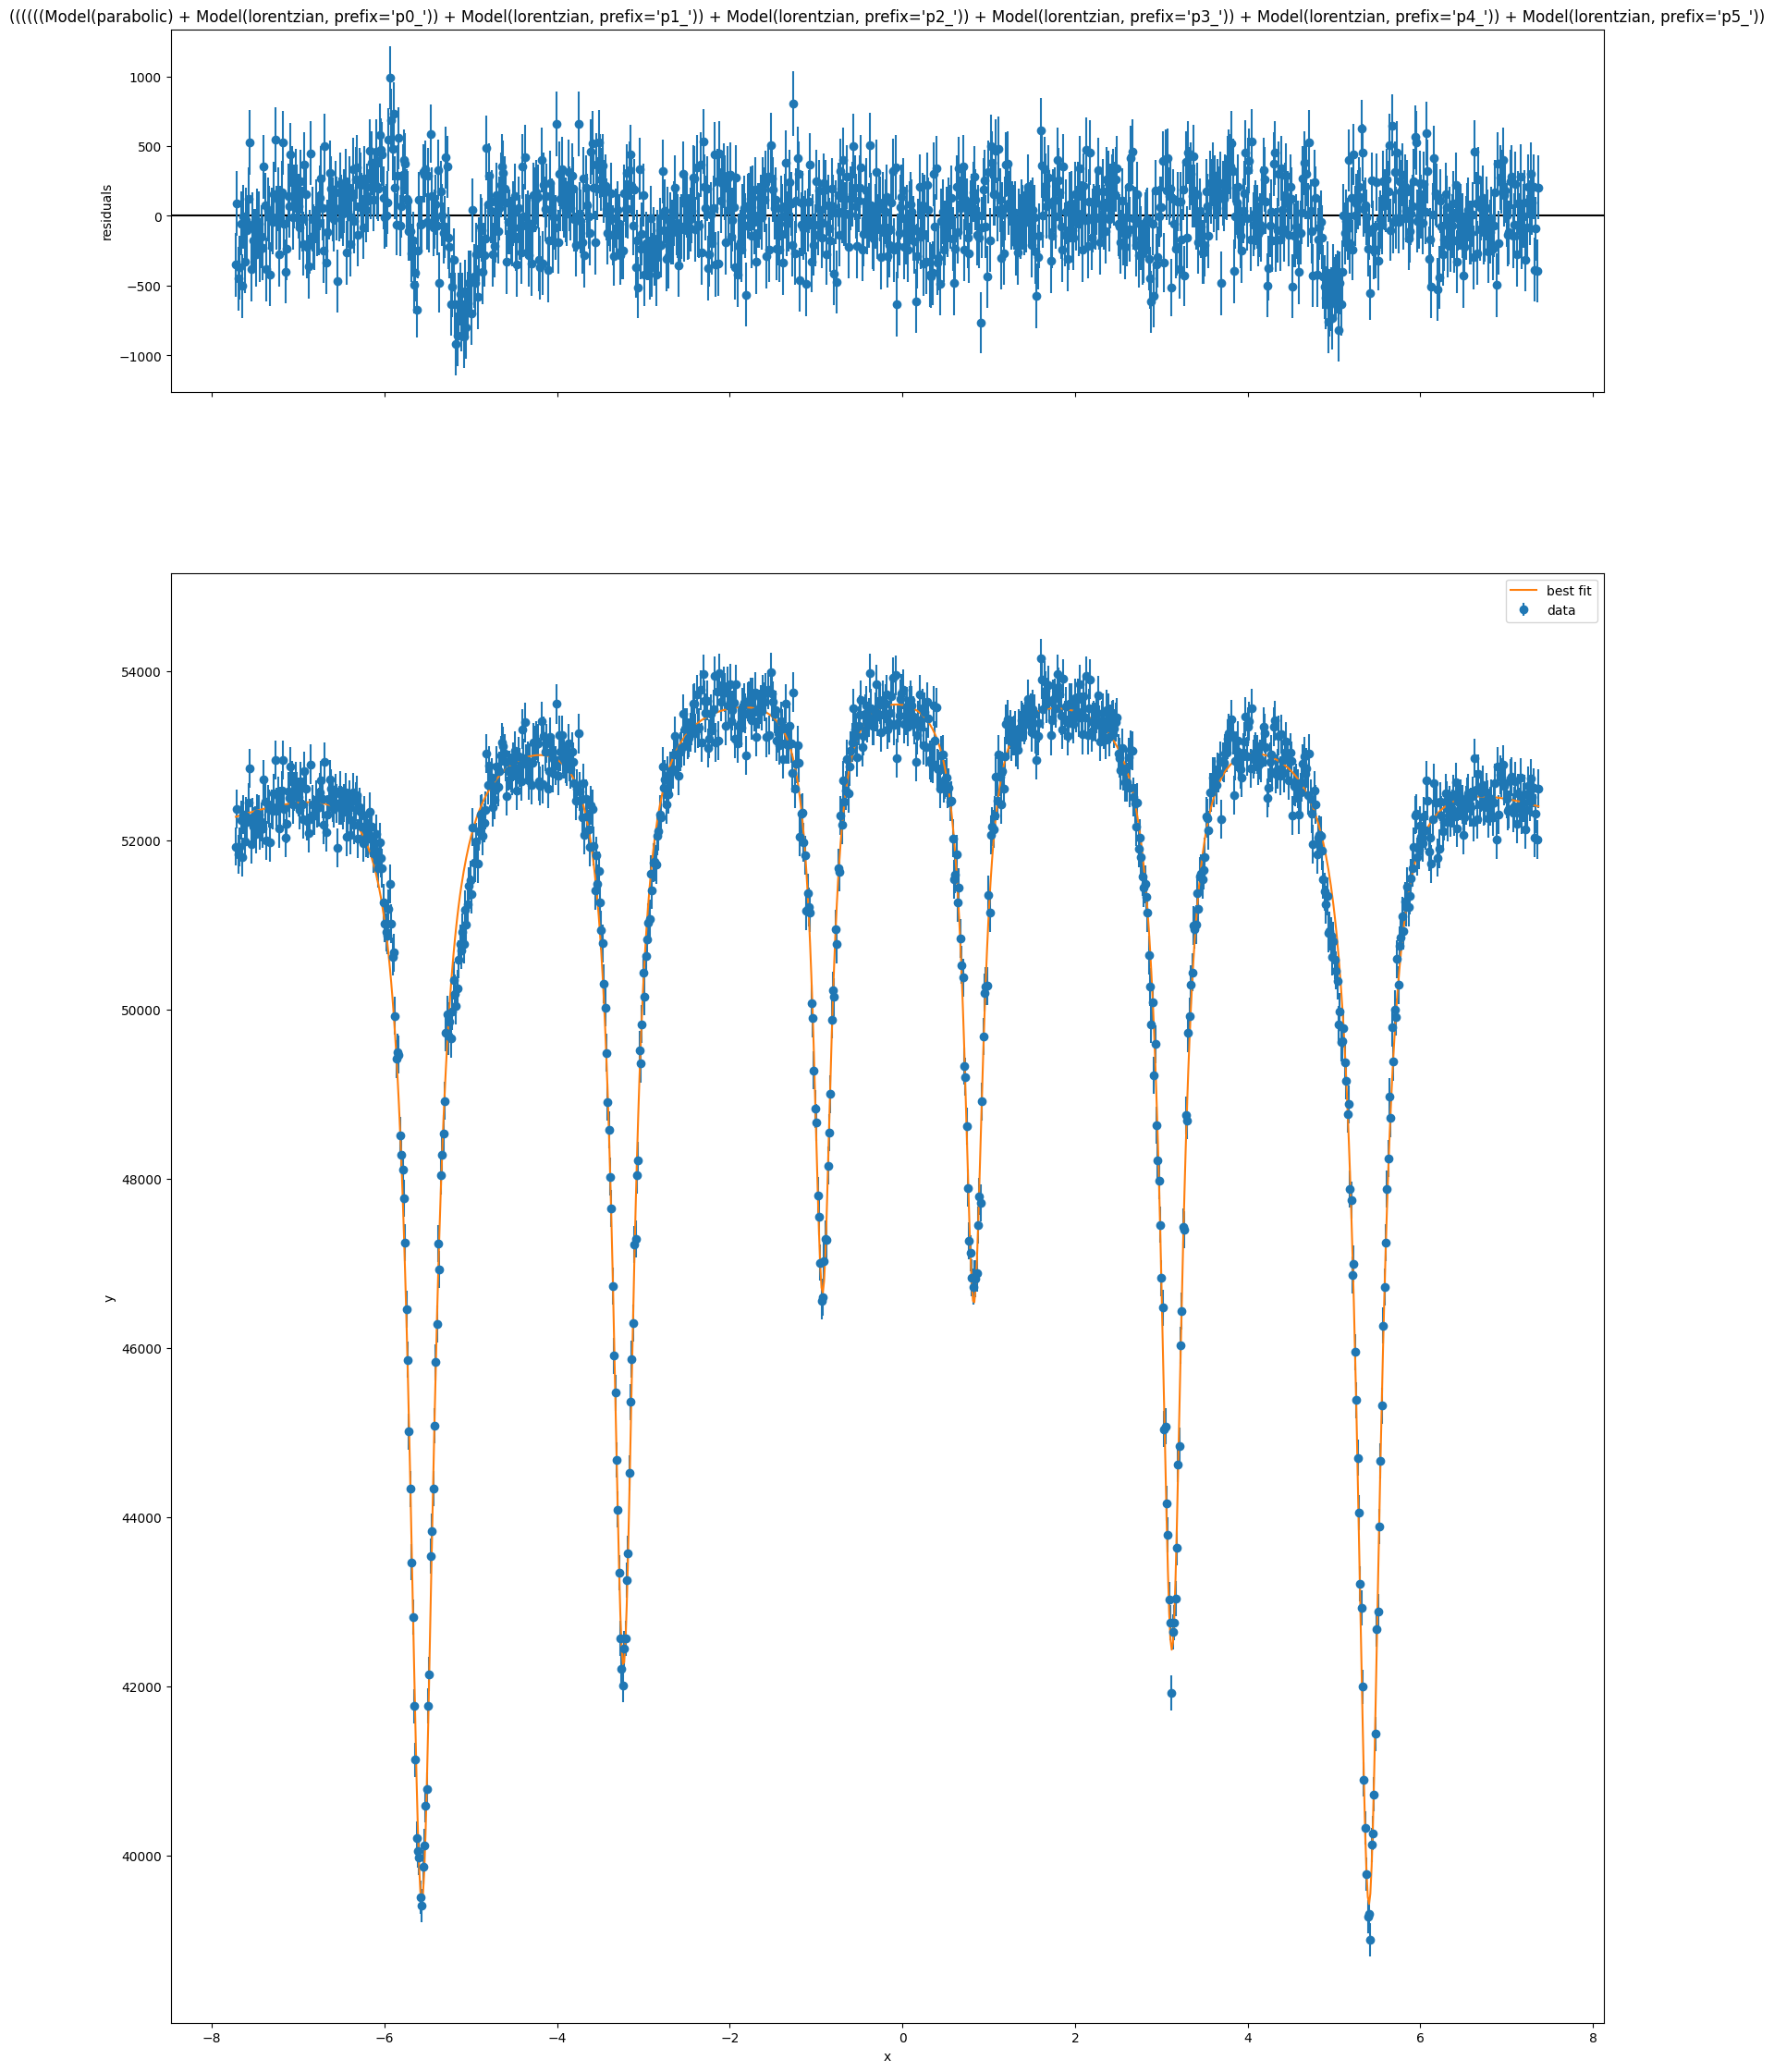

In [68]:
Fe_peaks_df_2, file_2_df = process_sample(
    "data/Natural Fe 0.001 in.txt",
    [-5.6, -3.2, -0.9, 0.9, 3.1, 5.5],
    "Natural Fe 0.001 in",
)


Peak locations for Enriched Fe 47.21mV:
   Number   Location (mm/s)
0       1  -5.7972+/-0.0013
1       2  -3.3689+/-0.0013
2       3  -0.9568+/-0.0016
3       4   0.8569+/-0.0016
4       5   3.2458+/-0.0012
5       6   5.6227+/-0.0013


/Users/bowanglan/Dev/academic/phys-431/mossbauer-spectroscopy/.venv/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


(   Number   Location (mm/s)
 0       1  -5.7972+/-0.0013
 1       2  -3.3689+/-0.0013
 2       3  -0.9568+/-0.0016
 3       4   0.8569+/-0.0016
 4       5   3.2458+/-0.0012
 5       6   5.6227+/-0.0013,
       Chan  Counts  velocity
 0        0   12785  7.367625
 1        1   12750  7.352875
 2        2   12559  7.338125
 3        3   12688  7.323375
 4        4   12501  7.308625
 ...    ...     ...       ...
 1019  1019   12694 -7.662625
 1020  1020   12559 -7.677375
 1021  1021   12509 -7.692125
 1022  1022   12604 -7.706875
 1023  1023   12658 -7.721625
 
 [1024 rows x 3 columns])

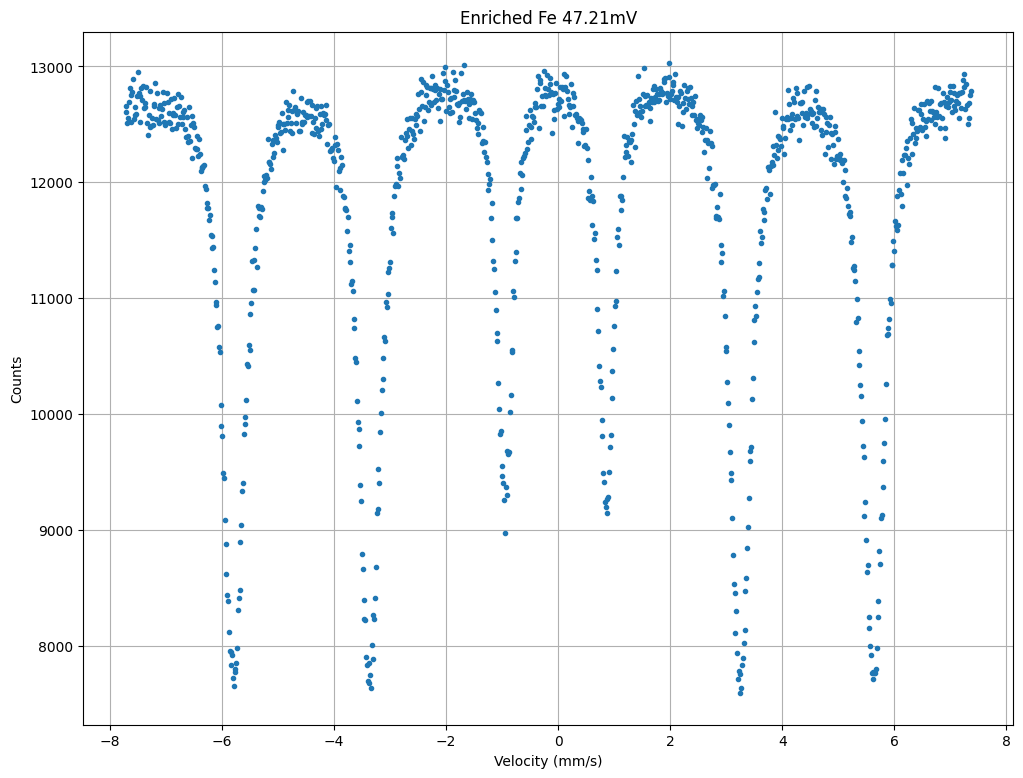

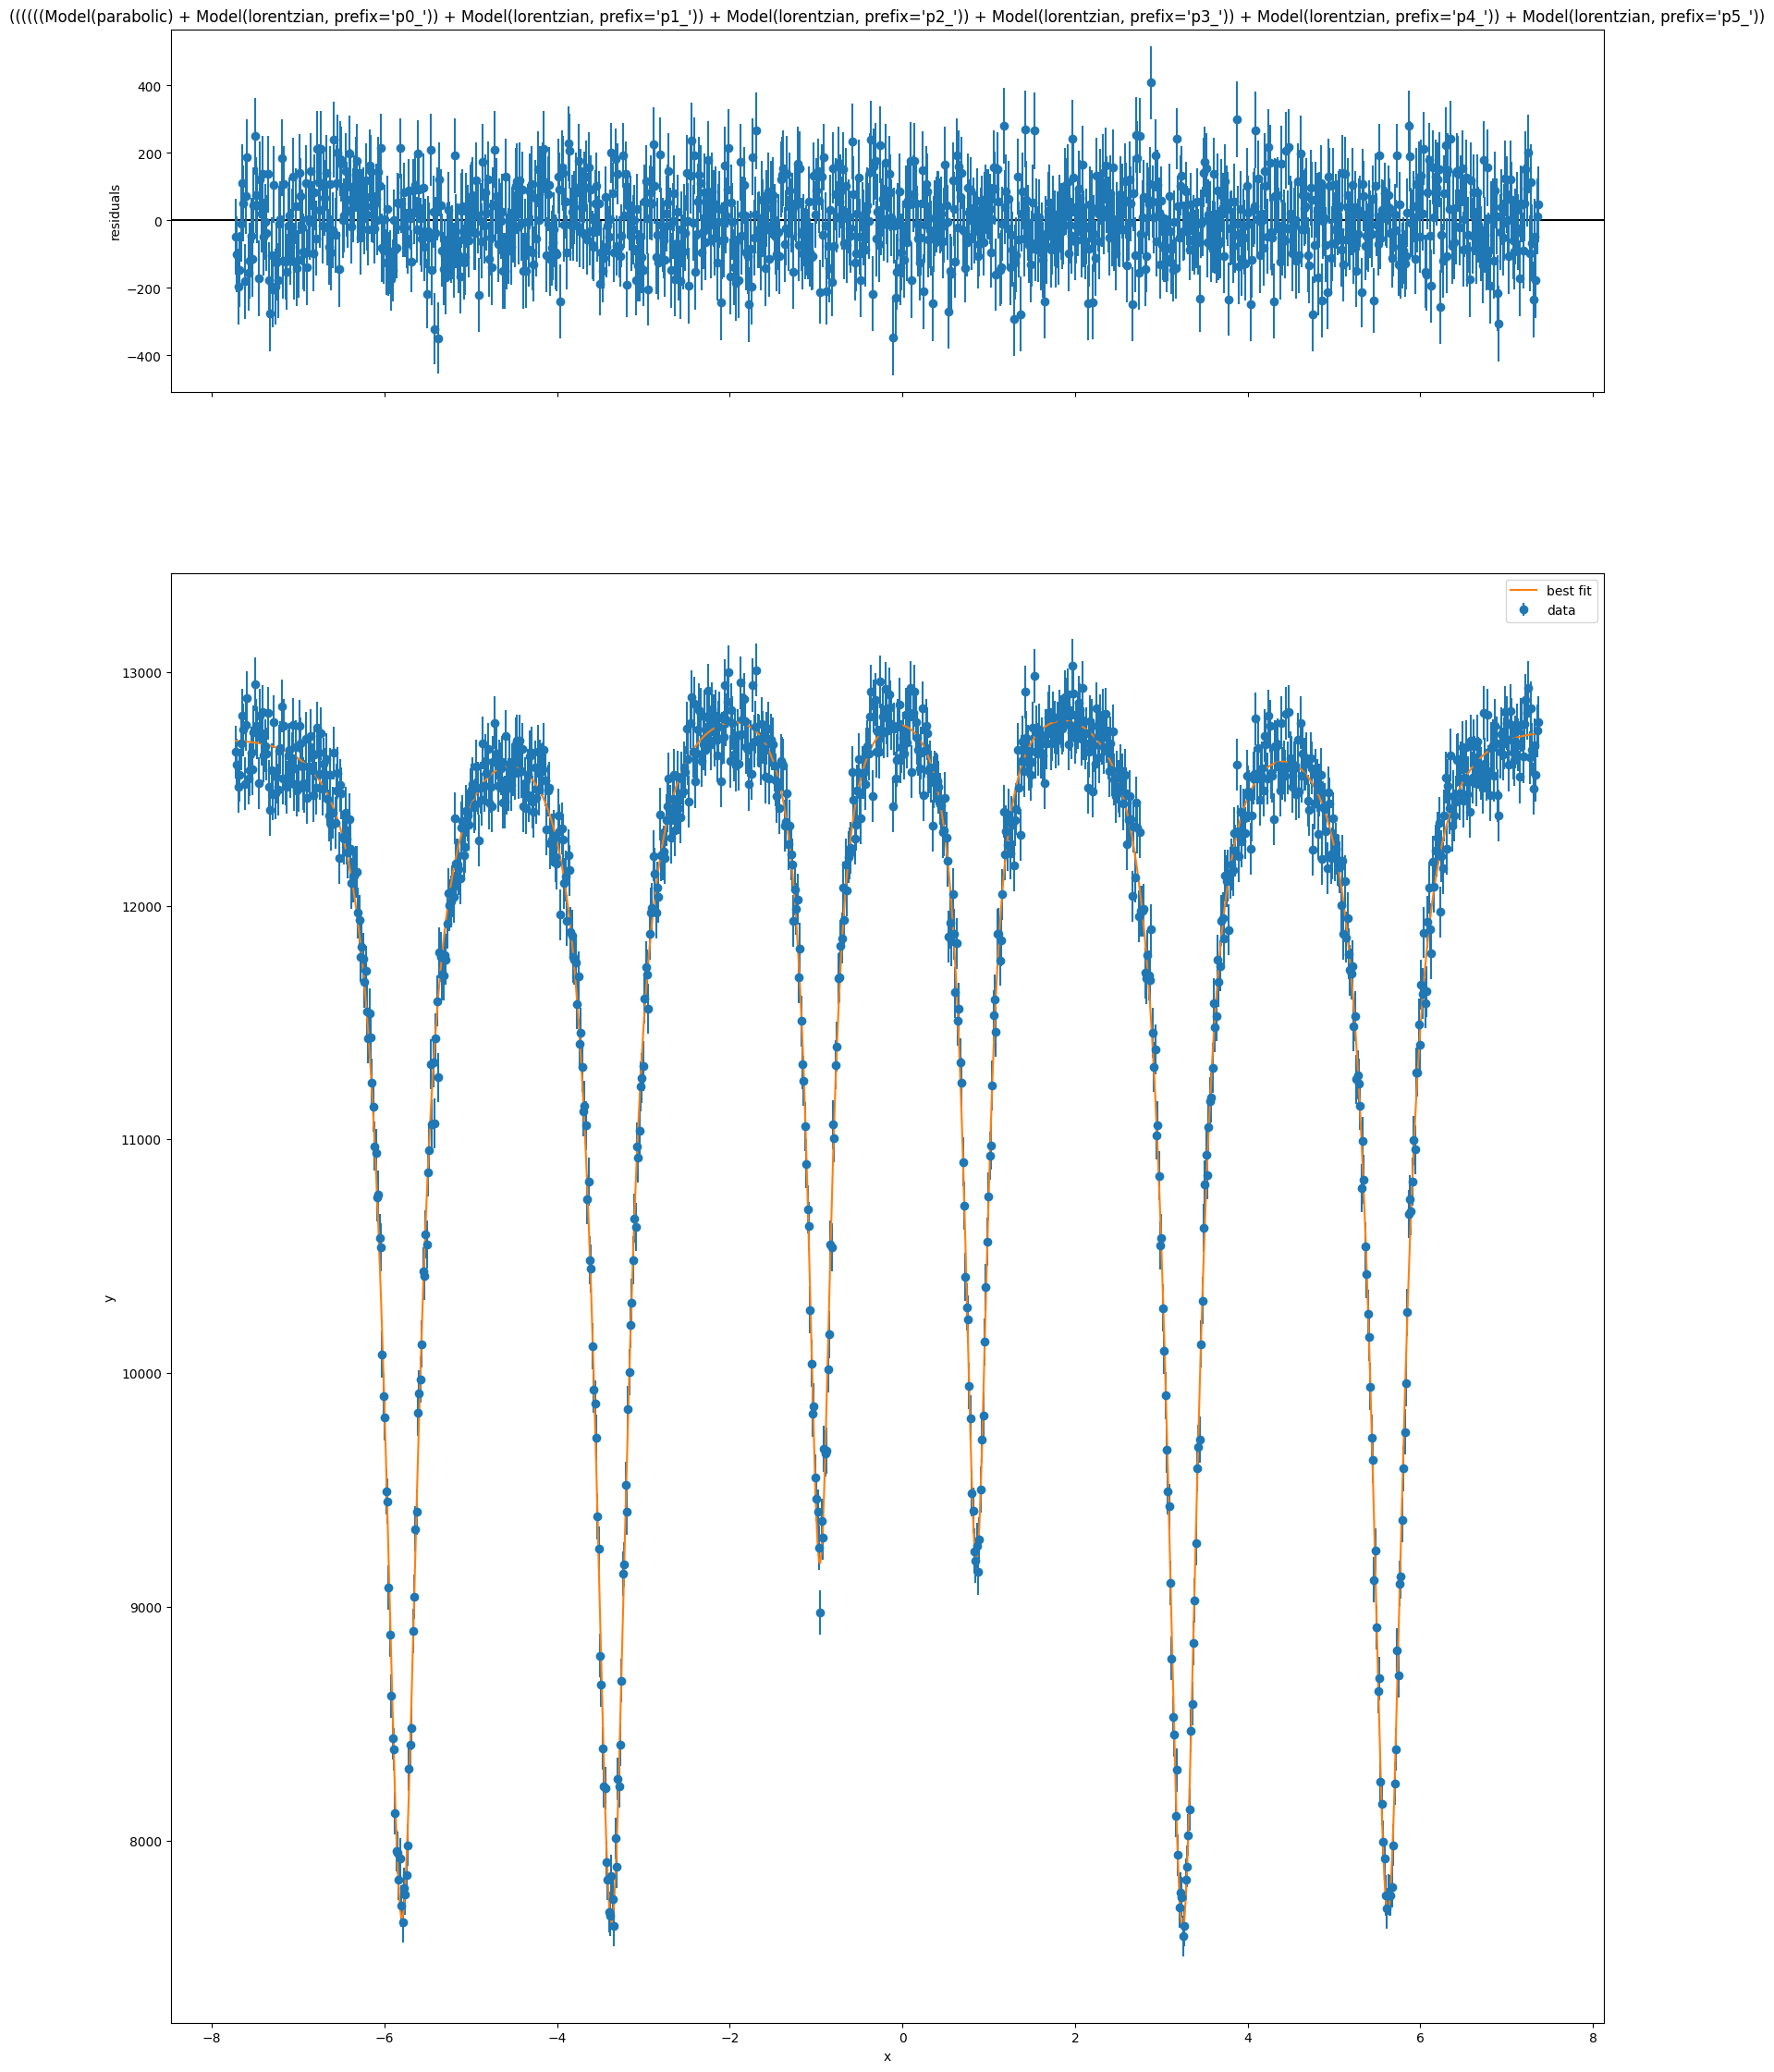

In [69]:
process_sample(
    "data/Enriched_Fe_47.21mV.txt",
    [-5.6, -3.2, -0.9, 0.9, 3.1, 5.5],
    "Enriched Fe 47.21mV",
)


Peak locations for Natural Fe 0.001 in:
   Number   Location (mm/s)
0       1  -0.4218+/-0.0020


/Users/bowanglan/Dev/academic/phys-431/mossbauer-spectroscopy/.venv/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


(   Number   Location (mm/s)
 0       1  -0.4218+/-0.0020,
       Chan  Counts  velocity
 0        0   11057  7.367625
 1        1   10821  7.352875
 2        2   11241  7.338125
 3        3   11054  7.323375
 4        4   11040  7.308625
 ...    ...     ...       ...
 1019  1019   10974 -7.662625
 1020  1020   11034 -7.677375
 1021  1021   11042 -7.692125
 1022  1022   11119 -7.706875
 1023  1023   11023 -7.721625
 
 [1024 rows x 3 columns])

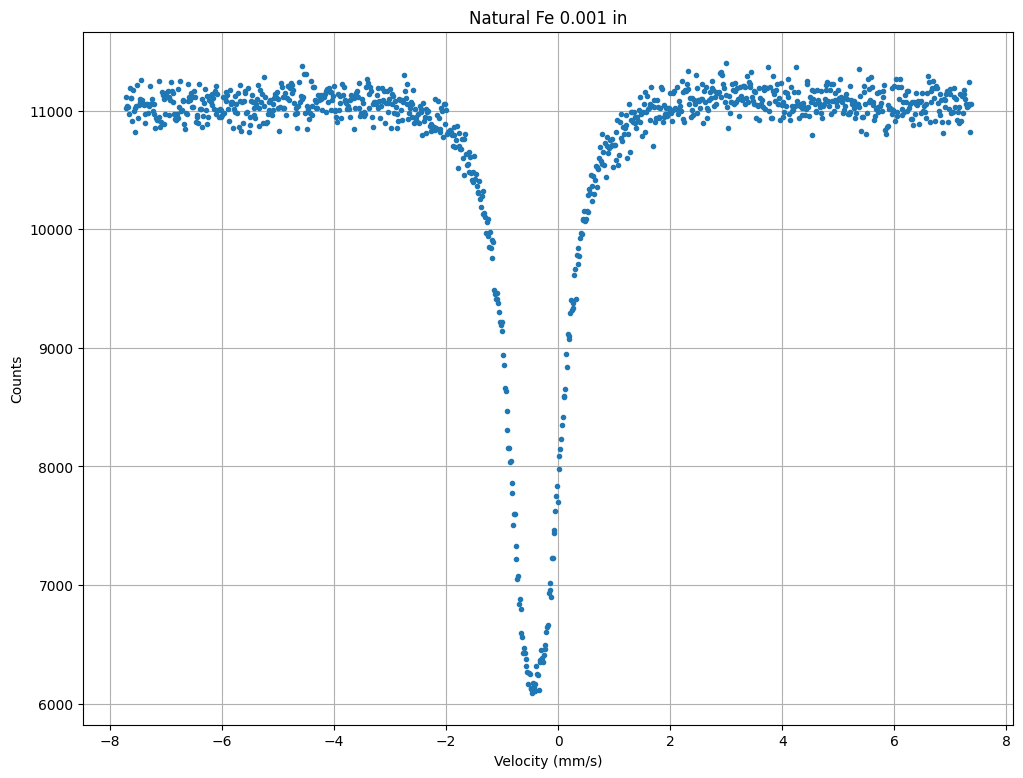

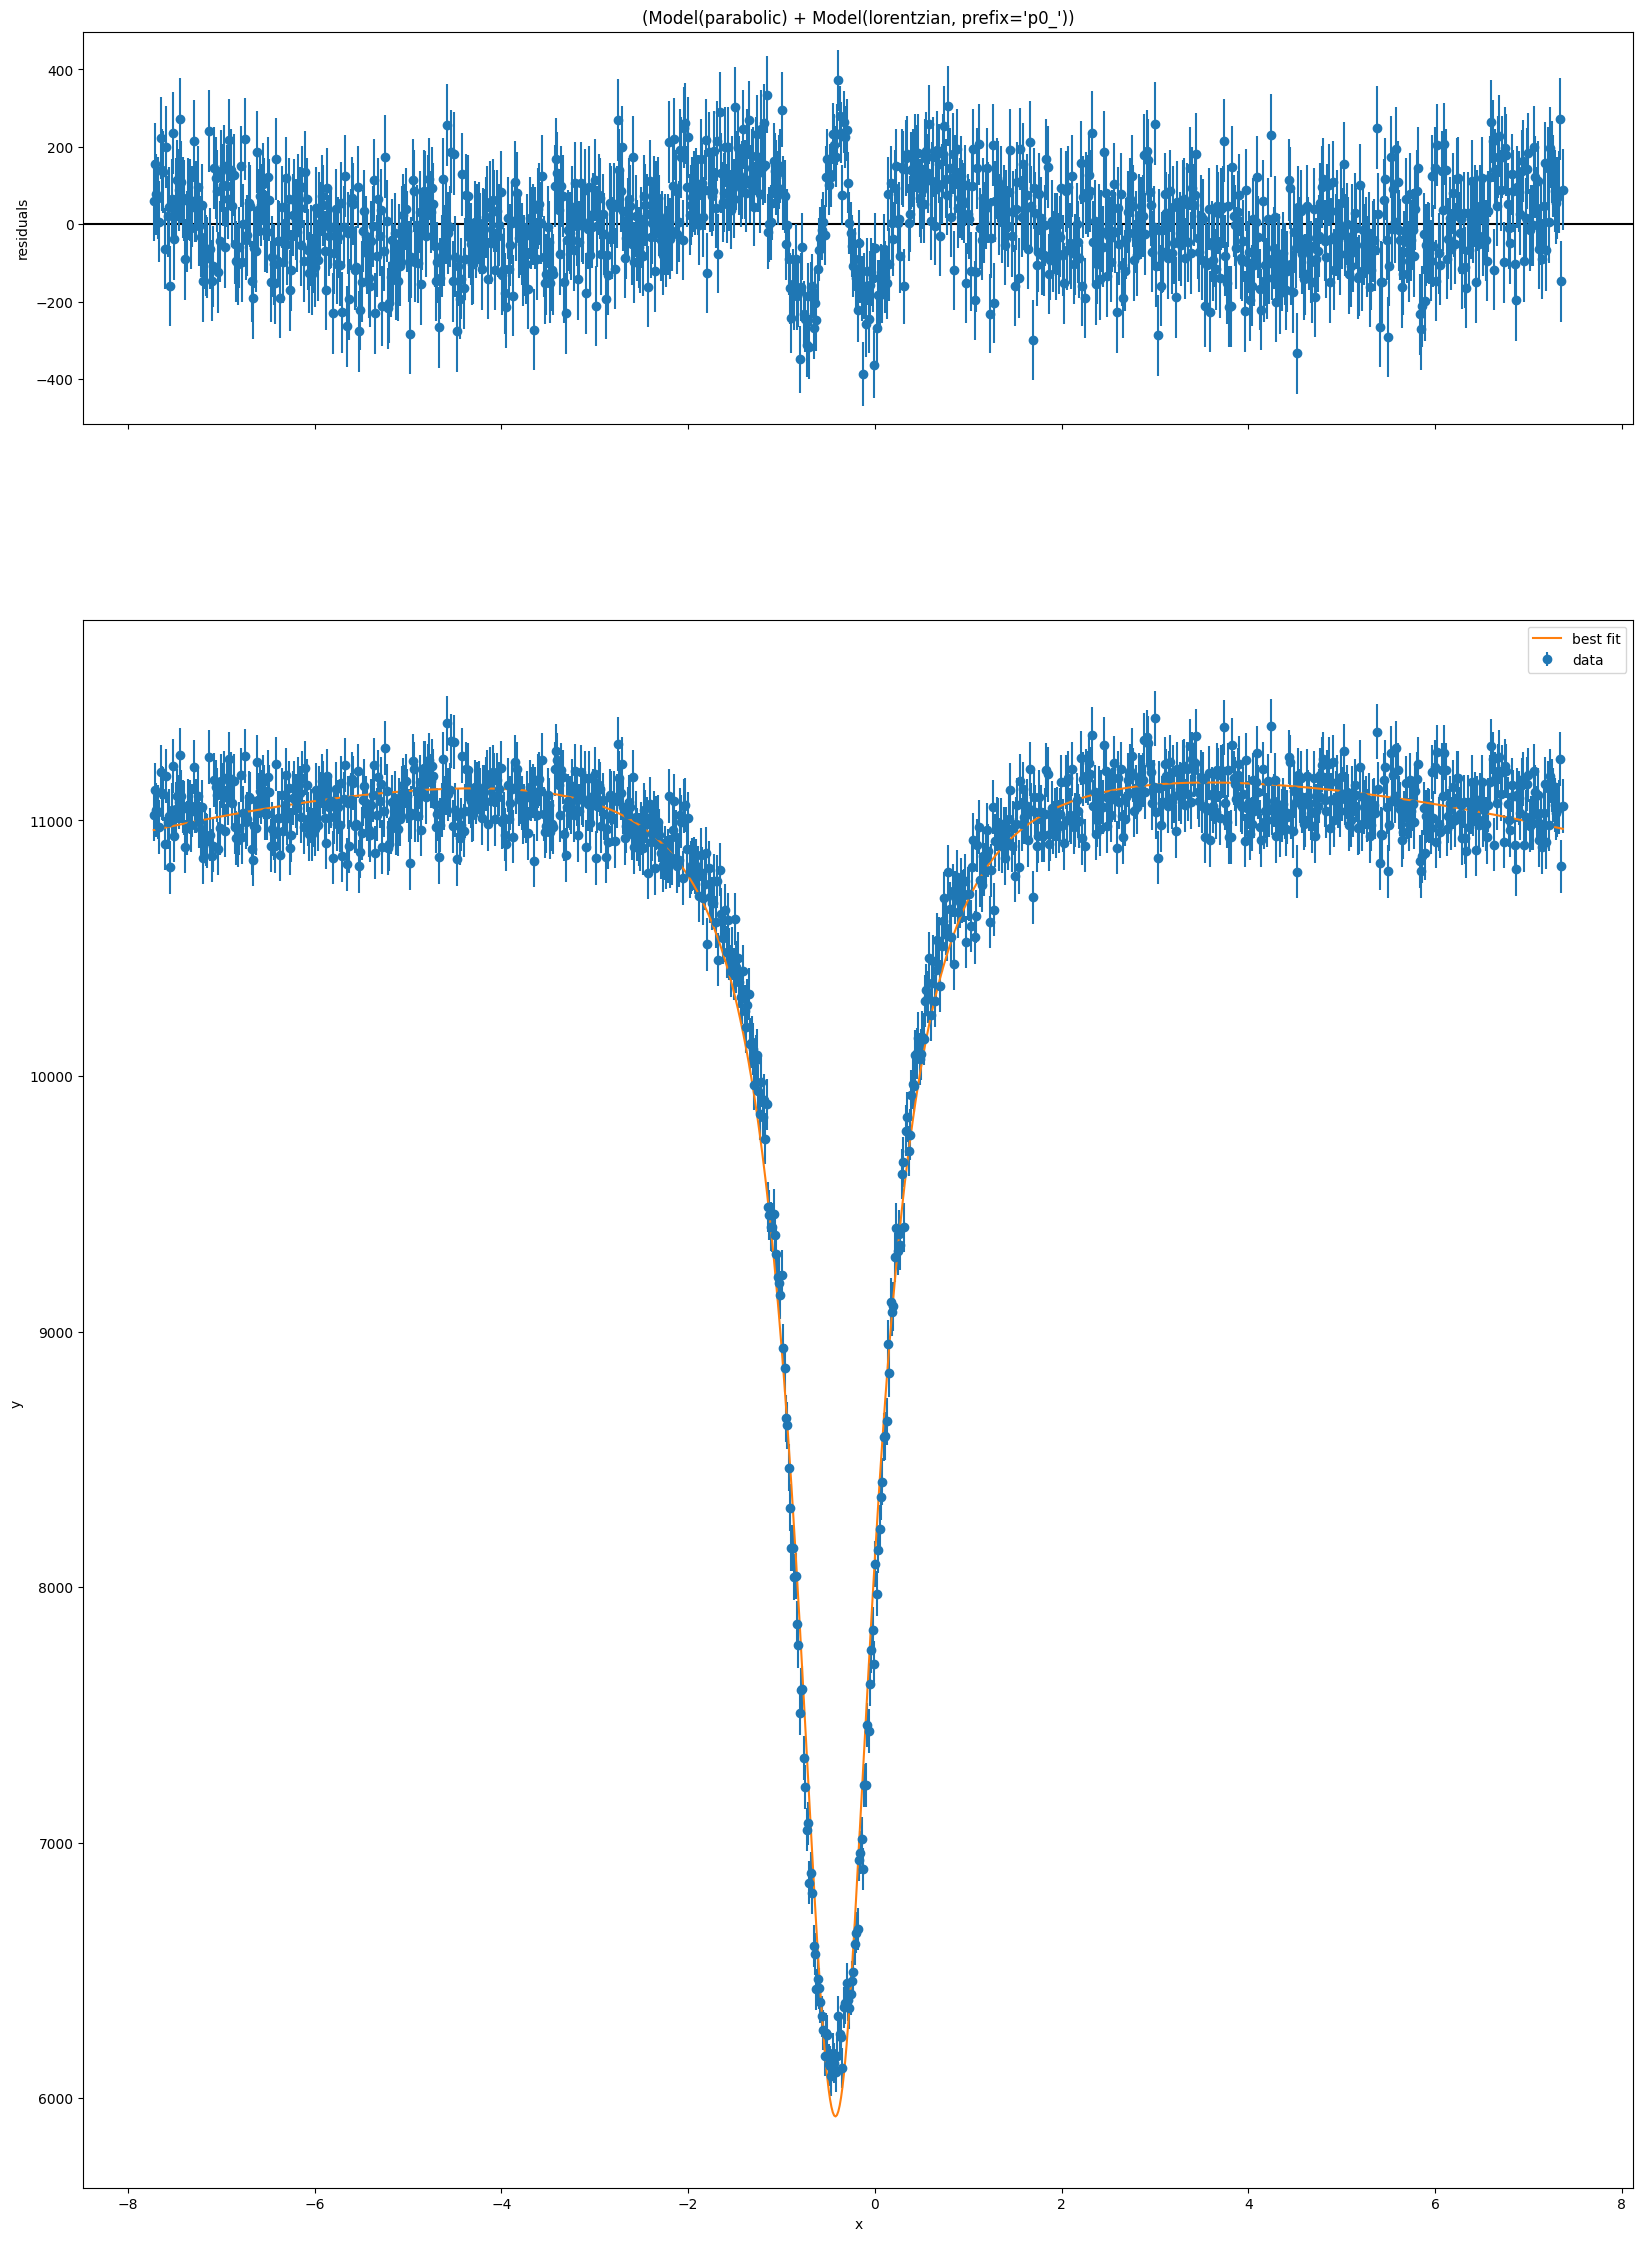

In [70]:
process_sample(
    "data/Stainless Fe-transducer unconnected.txt",
    [0],
    "Natural Fe 0.001 in",
)



Peak locations for 0.00025 in Fe:
   Number   Location (mm/s)
0       1  -5.5564+/-0.0025
1       2  -3.2263+/-0.0030
2       3    -0.915+/-0.005
3       4     0.821+/-0.006
4       5   3.1189+/-0.0031
5       6   5.4043+/-0.0025


/Users/bowanglan/Dev/academic/phys-431/mossbauer-spectroscopy/.venv/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


(   Number   Location (mm/s)
 0       1  -5.5564+/-0.0025
 1       2  -3.2263+/-0.0030
 2       3    -0.915+/-0.005
 3       4     0.821+/-0.006
 4       5   3.1189+/-0.0031
 5       6   5.4043+/-0.0025,
       Chan  Counts  velocity
 0        0   38842  7.367625
 1        1   38606  7.352875
 2        2   38678  7.338125
 3        3   38782  7.323375
 4        4   38581  7.308625
 ...    ...     ...       ...
 1019  1019   38875 -7.662625
 1020  1020   38605 -7.677375
 1021  1021   38588 -7.692125
 1022  1022   38653 -7.706875
 1023  1023   38712 -7.721625
 
 [1024 rows x 3 columns])

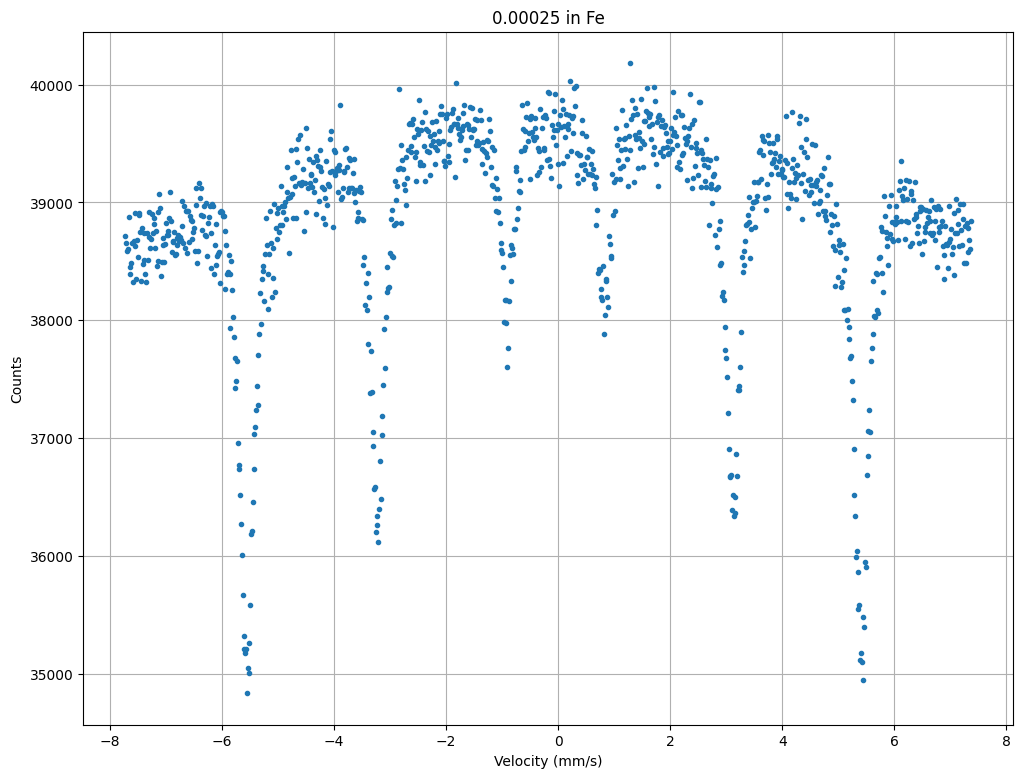

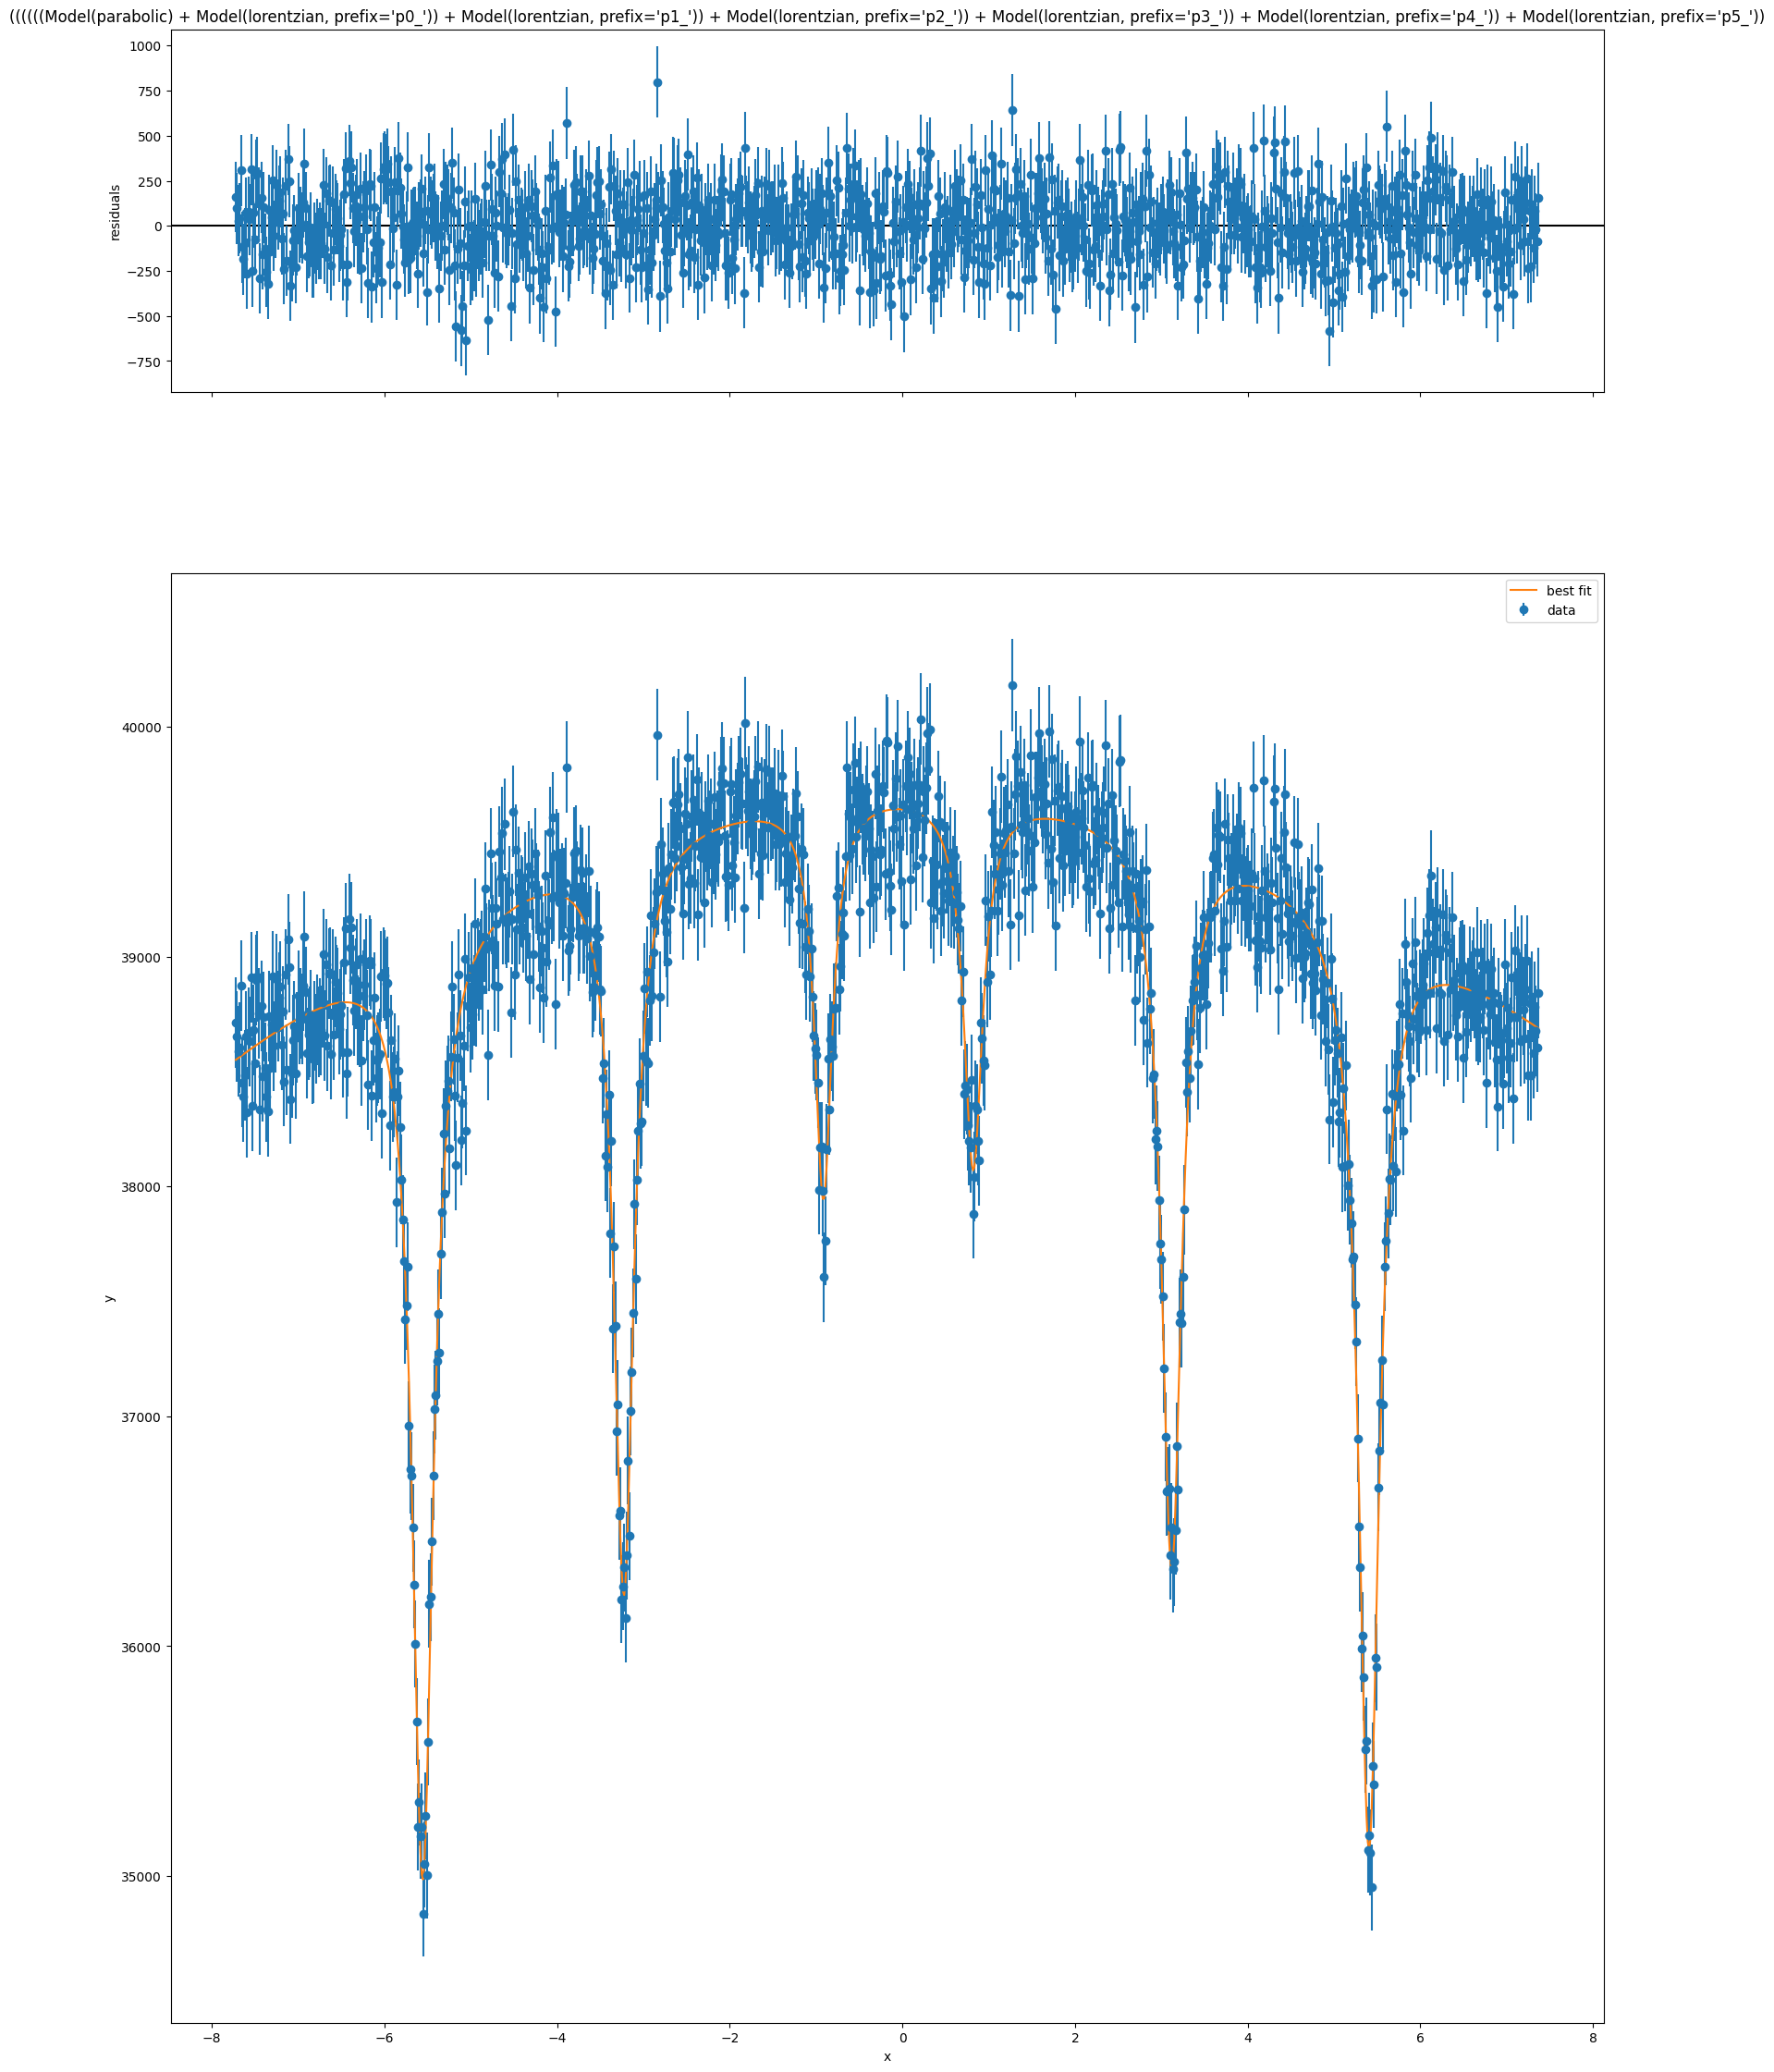

In [71]:
process_sample(
    "data/0.00025 in  Fe.txt",
    [-5.6, -3.2, -0.9, 0.9, 3.1, 5.5],
    "0.00025 in Fe",
)



Peak locations for Hematite 73.5mV:
   Number   Location (mm/s)
0       1  -5.6049+/-0.0016
1       2  -3.0164+/-0.0019
2       3  -0.5812+/-0.0031
3       4     1.228+/-0.004
4       5   3.6365+/-0.0020
5       6   5.8709+/-0.0016


/Users/bowanglan/Dev/academic/phys-431/mossbauer-spectroscopy/.venv/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


(   Number   Location (mm/s)
 0       1  -5.6049+/-0.0016
 1       2  -3.0164+/-0.0019
 2       3  -0.5812+/-0.0031
 3       4     1.228+/-0.004
 4       5   3.6365+/-0.0020
 5       6   5.8709+/-0.0016,
       Chan  Counts  velocity
 0        0  107303  7.367625
 1        1  107224  7.352875
 2        2  107315  7.338125
 3        3  107308  7.323375
 4        4  107347  7.308625
 ...    ...     ...       ...
 1019  1019  107121 -7.662625
 1020  1020  106559 -7.677375
 1021  1021  107227 -7.692125
 1022  1022  107579 -7.706875
 1023  1023  106567 -7.721625
 
 [1024 rows x 3 columns])

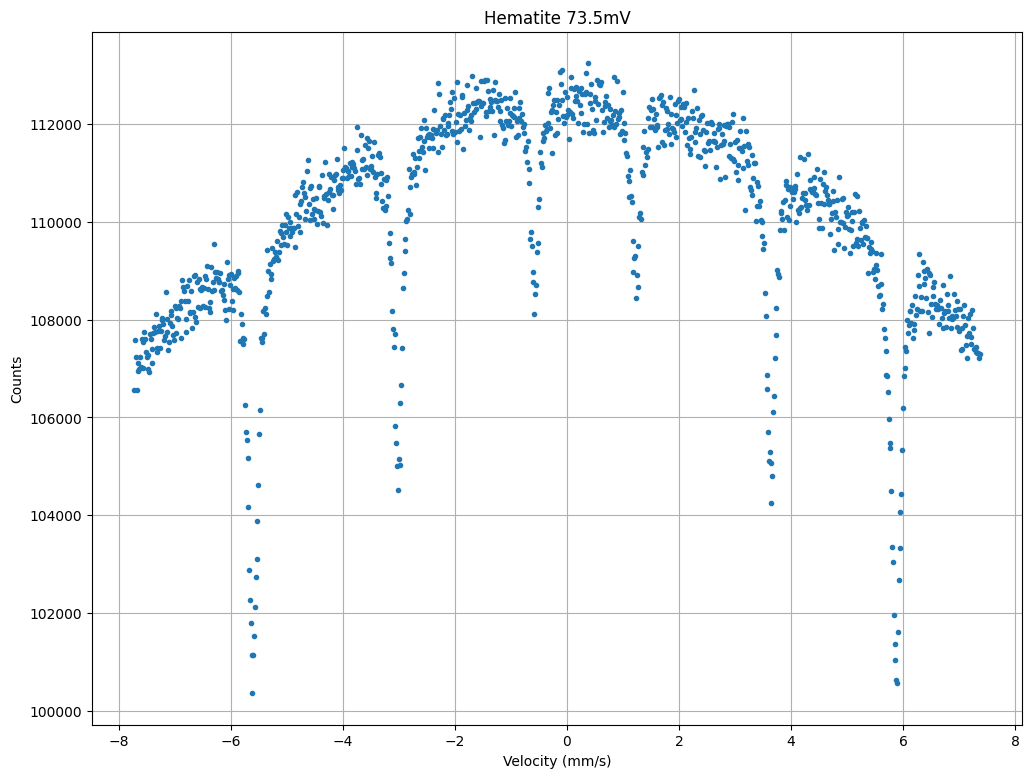

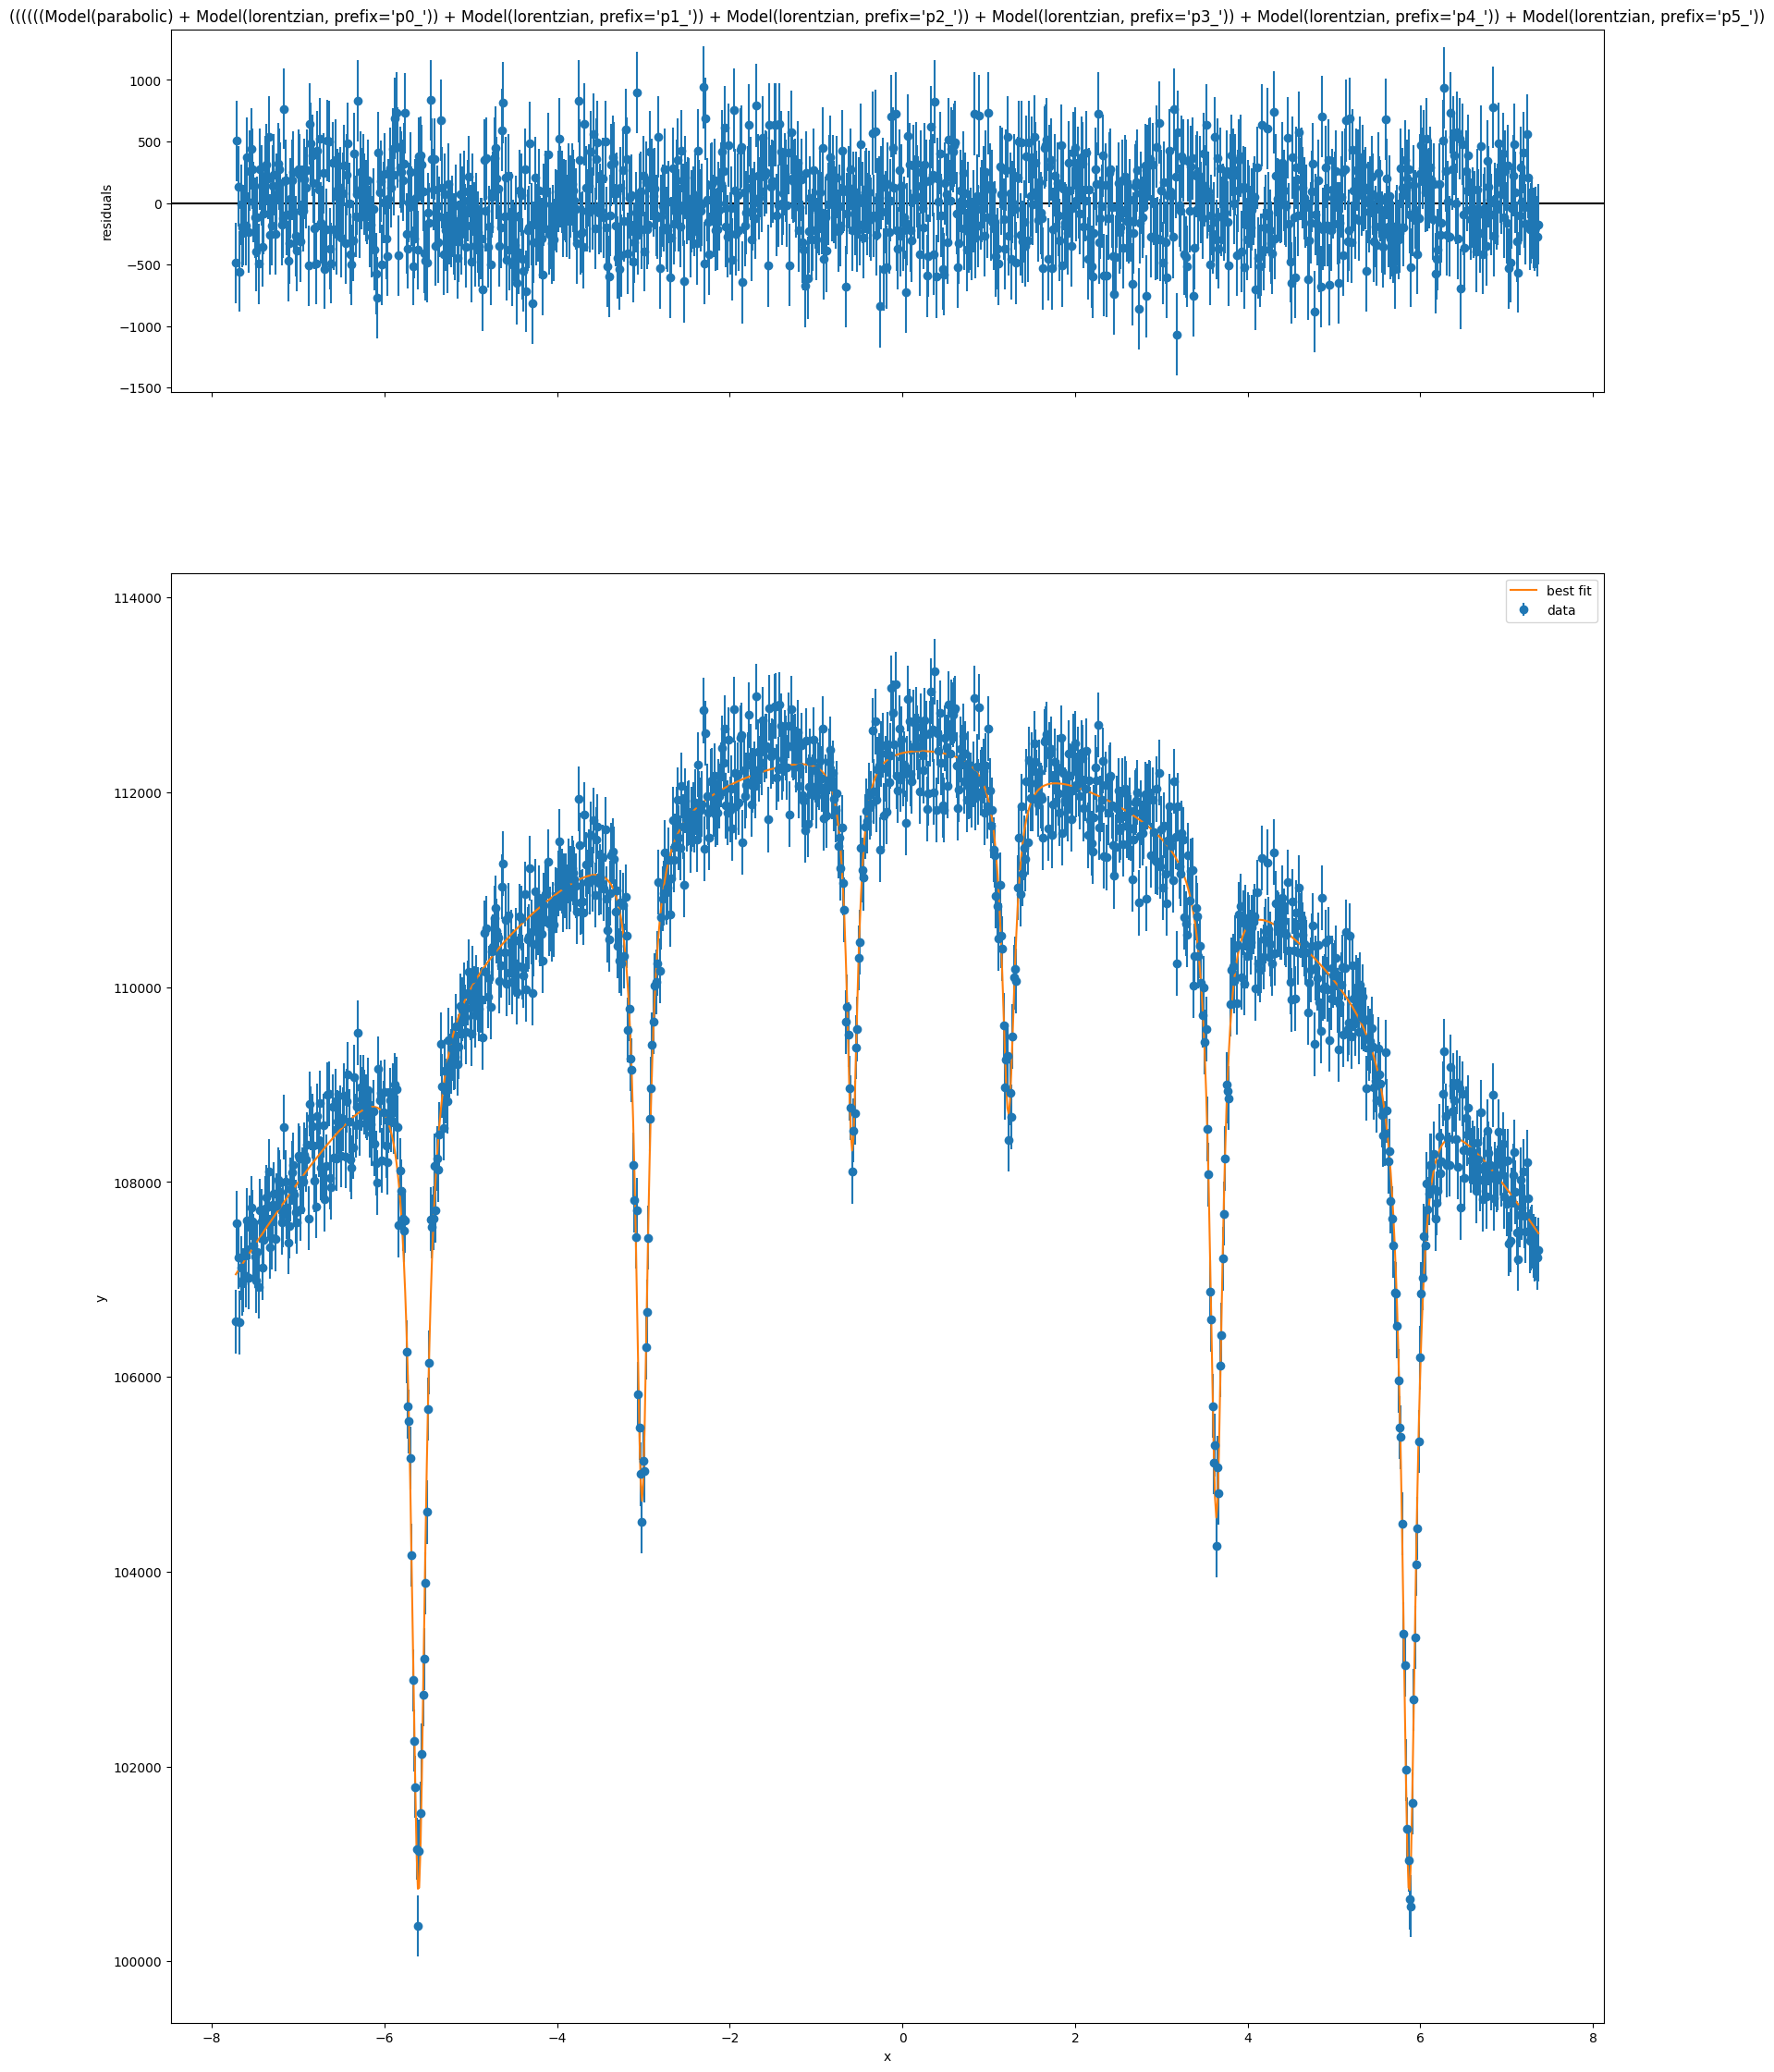

In [72]:
process_sample(
    "data/Hematite 73.5mV.txt",
    [-5.6, -3.2, -0.9, 0.9, 3.1, 5.5],
    "Hematite 73.5mV",
)


/Users/bowanglan/Dev/academic/phys-431/mossbauer-spectroscopy/.venv/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")



Peak locations for Sodium Nitroprusside:
   Number Location (mm/s)
0       1  -2.766+/-0.005
1       2   1.174+/-0.006


(   Number Location (mm/s)
 0       1  -2.766+/-0.005
 1       2   1.174+/-0.006,
       Chan  Counts  velocity
 0        0   37534  7.367625
 1        1   37538  7.352875
 2        2   37402  7.338125
 3        3   37630  7.323375
 4        4   37768  7.308625
 ...    ...     ...       ...
 1019  1019   37715 -7.662625
 1020  1020   37417 -7.677375
 1021  1021   37656 -7.692125
 1022  1022   37357 -7.706875
 1023  1023   37523 -7.721625
 
 [1024 rows x 3 columns])

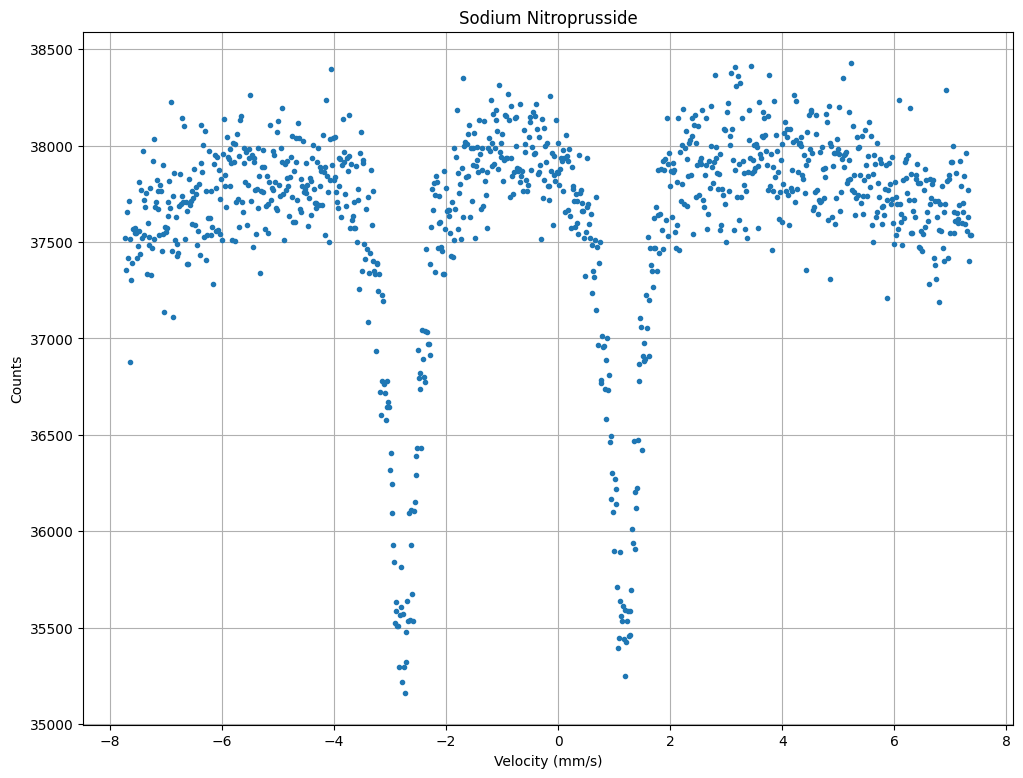

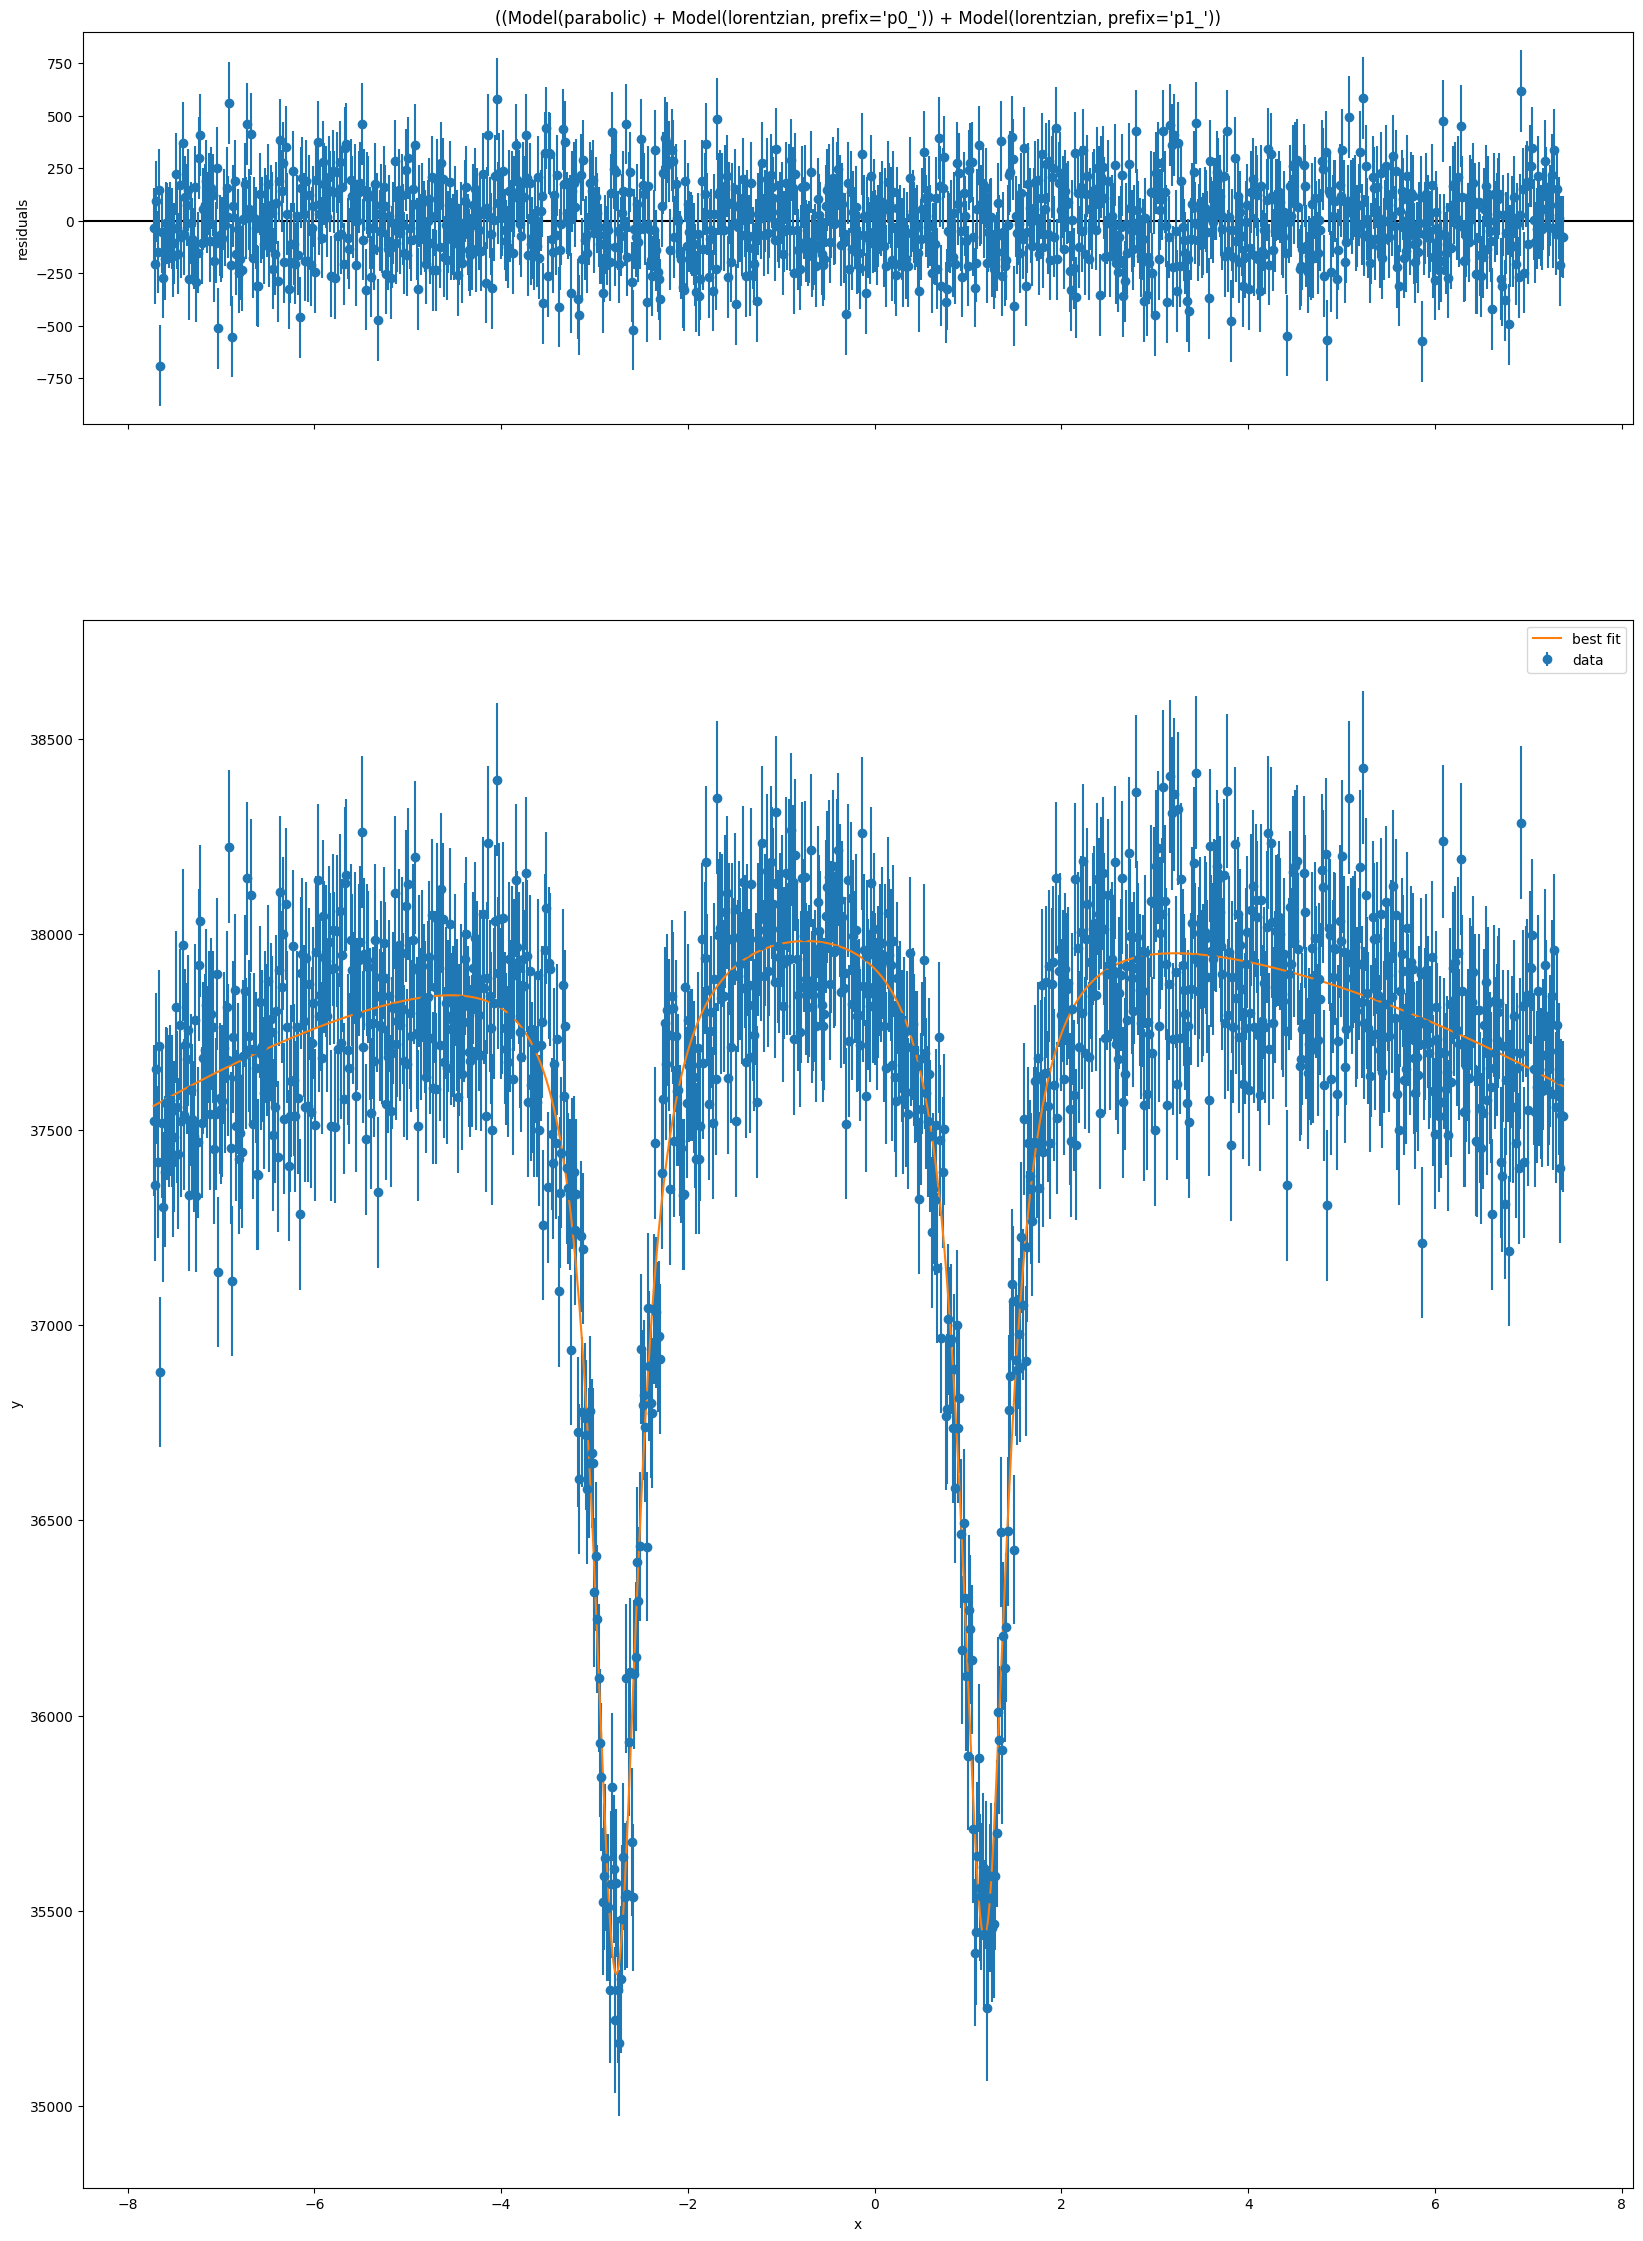

In [73]:
process_sample(
    "data/Sodium Nitroprusside.txt",
    [-3,1],
    "Sodium Nitroprusside",
)